# 📝  Image Filtering

![](./assets/figures/1_image_filters_77_0.png)

## Image filtering theory


Filtering is one of the most basic and common image operations in image processing. You can filter an image to remove noise or to enhance features; the filtered image could be the desired result or just a preprocessing step. Regardless, filtering is an important topic to understand.


### Local filtering


In [12]:
import matplotlib.pyplot as plt
import numpy as np

# This just sets the plotting format
plt.rcParams["image.cmap"] = "gray"

The "local" in local filtering simply means that a pixel is adjusted by values in some surrounding neighborhood. These surrounding elements are identified or weighted based on a "footprint", "structuring element", or "kernel".


Let's go to back to basics and look at a 1D step-signal


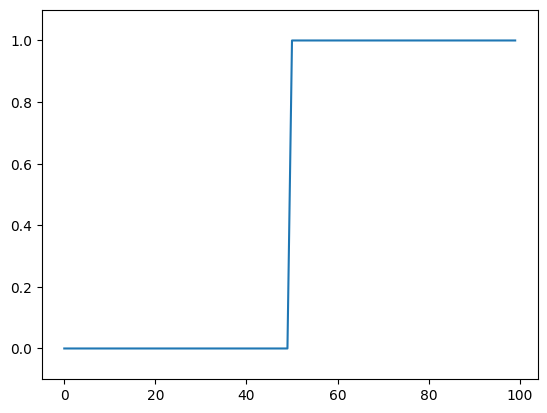

In [13]:
# creates a zero array
step_signal = np.zeros(100)

# replaces from 50 on with a value of 1
step_signal[50:] = 1

# plots the data
fig, ax = plt.subplots()
ax.plot(step_signal)
ax.margins(y=0.1)


Now add some noise to this signal:


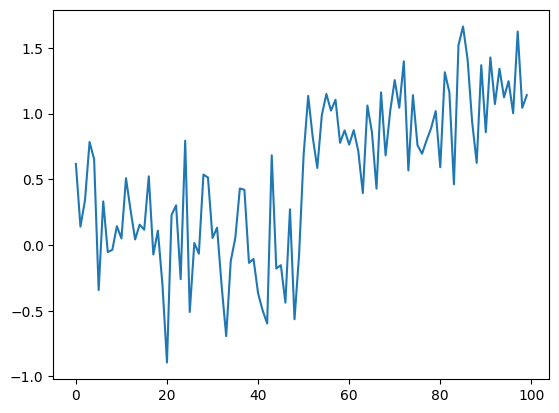

In [14]:
# Just to make sure we all see the same results
np.random.seed(0)

# Adds noise to the data
noisy_signal = step_signal + np.random.normal(0, 0.35, step_signal.shape)
fig, ax = plt.subplots()
ax.plot(noisy_signal)

The simplest way to recover something that looks a bit more like the original signal is to take the average between neighboring "pixels":


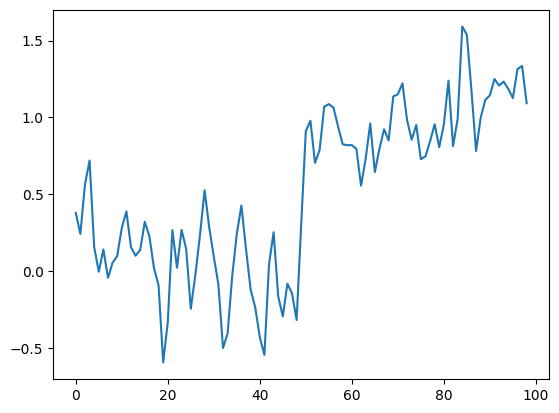

In [15]:
# Take the mean of neighboring pixels
smooth_signal = (noisy_signal[:-1] + noisy_signal[1:]) / 2.0
fig, ax = plt.subplots()
ax.plot(smooth_signal)

What happens if we want to take the _three_ neighboring pixels? We can do the same thing:


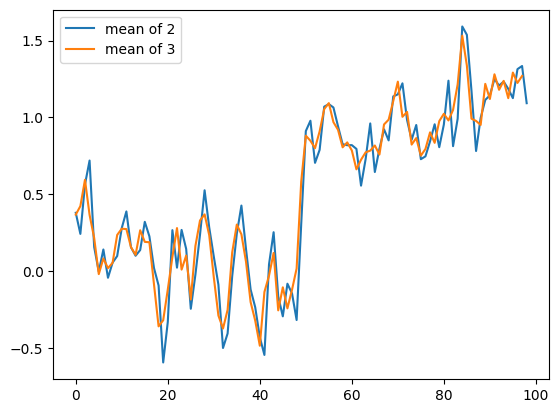

In [16]:
# smooth with size 3 points
smooth_signal3 = (noisy_signal[:-2] + noisy_signal[1:-1] + noisy_signal[2:]) / 3
fig, ax = plt.subplots()
ax.plot(smooth_signal, label="mean of 2")
ax.plot(smooth_signal3, label="mean of 3")
ax.legend(loc="upper left")

For averages of more points, the expression keeps getting hairier. And you have to worry more about what's happening in the margins. Is there a better way?


It turns out there is. This same concept, nearest-neighbor averages, can be expressed as a _convolution_ with an _averaging kernel_. Note that the operation we did with `smooth_signal3` can be expressed as follows:

- Create an output array called `smooth_signal3`, of the same length as `noisy_signal`.
- At each element in `smooth_signal3` starting at point 1, and ending at point -2, place the average of the sum of: 1/3 of the element to the left of it in `noisy_signal`, 1/3 of the element at the same position, and 1/3 of the element to the right.
- discard the leftmost and rightmost elements.


This is called a _convolution_ between the input image and the array `[1/3, 1/3, 1/3]`.

We'll give a more in-depth explanation of convolution in the next section


smooth_signal3 and smooth_signal3p are equal: True


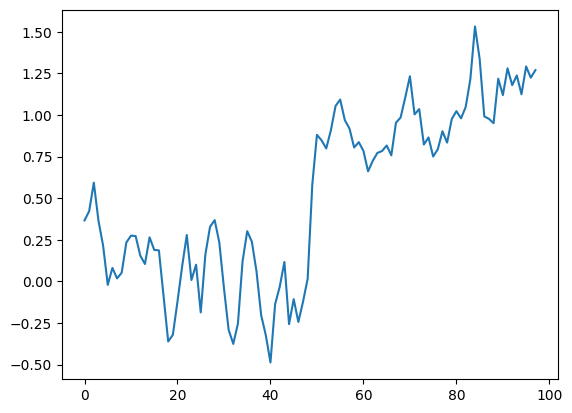

In [17]:
# Same as above, using a convolution kernel
# Neighboring pixels multiplied by 1/3 and summed
mean_kernel3 = np.full((3,), 1 / 3)
smooth_signal3p = np.convolve(noisy_signal, mean_kernel3, mode="valid")
fig, ax = plt.subplots()
ax.plot(smooth_signal3p)

# shows that the two curves are equal.
print(
    "smooth_signal3 and smooth_signal3p are equal:",
    np.allclose(smooth_signal3, smooth_signal3p),
)


In [18]:
from ipywidgets import interact, widgets

def convolve_demo(signal, kernel):
    ksize = len(kernel)
    convolved = np.correlate(signal, kernel)

    def filter_step(i):
        fig, ax = plt.subplots()
        ax.plot(signal, label="signal")
        ax.plot(convolved[: i + 1], label="convolved")
        ax.legend()
        ax.scatter(np.arange(i, i + ksize), signal[i : i + ksize])
        ax.scatter(i, convolved[i])

    return filter_step


# This adds a simple interactive slider from Ipywidgets
i_slider = widgets.IntSlider(min=0, max=len(noisy_signal) - 3, value=0)

# This sets what happens on an interaction
interact(convolve_demo(noisy_signal, mean_kernel3), i=i_slider)


interactive(children=(IntSlider(value=0, description='i', max=97), Output()), _dom_classes=('widget-interact',…

<function __main__.convolve_demo.<locals>.filter_step(i)>

The advantage of convolution is that it's just as easy to take the average of 11 points as 3:


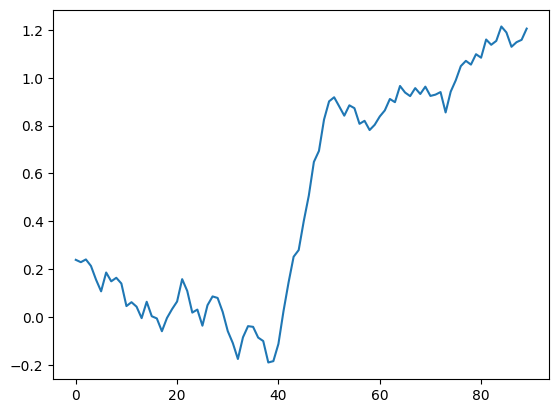

In [19]:
# builds the size 11 mean kernel
mean_kernel11 = np.full((11,), 1 / 11)

# convolves the kernel over the signal
smooth_signal11 = np.convolve(noisy_signal, mean_kernel11, mode="valid")
fig, ax = plt.subplots()
ax.plot(smooth_signal11)

In [20]:
# interactive example with a size 11 kernel
i_slider = widgets.IntSlider(min=0, max=len(noisy_signal) - 11, value=0)

interact(convolve_demo(noisy_signal, mean_kernel11), i=i_slider)

interactive(children=(IntSlider(value=0, description='i', max=89), Output()), _dom_classes=('widget-interact',…

<function __main__.convolve_demo.<locals>.filter_step(i)>

Of course, to take the mean of 11 values, we have to move further and further away from the edges, and this starts to be noticeable. You can use `mode='same'` to pad the edges of the array and compute a result of the same size as the input:


Text(0.5, 1.0, 'mode=same')

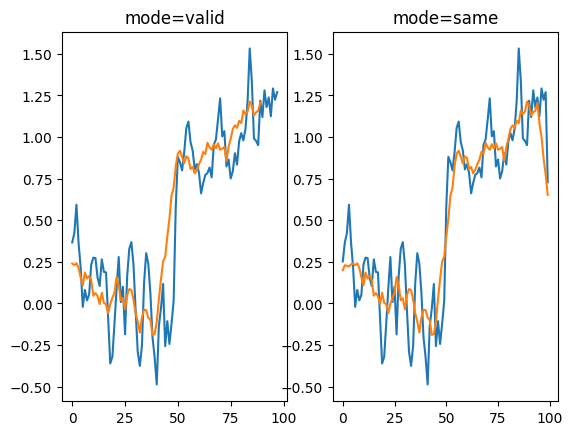

In [21]:
# shows the difference between different convolution modes.
# Same assumes the end is 0.
smooth_signal3same = np.convolve(noisy_signal, mean_kernel3, mode="same")
smooth_signal11same = np.convolve(noisy_signal, mean_kernel11, mode="same")

fig, ax = plt.subplots(1, 2)
ax[0].plot(smooth_signal3p)
ax[0].plot(smooth_signal11)
ax[0].set_title("mode=valid")
ax[1].plot(smooth_signal3same)
ax[1].plot(smooth_signal11same)
ax[1].set_title("mode=same")

But now we see edge effects on the ends of the signal...

This is because `mode='same'` actually pads the signal with 0s and then applies `mode='valid'` as before.


In [22]:
# shows this in an interactive form
def convolve_demo_same(signal, kernel):
    ksize = len(kernel)
    padded_signal = np.pad(signal, ksize // 2, mode="constant")
    convolved = np.correlate(padded_signal, kernel)

    def filter_step(i):
        fig, ax = plt.subplots()
        x = np.arange(-ksize // 2, len(signal) + ksize // 2)
        ax.plot(signal, label="signal")
        ax.plot(convolved[: i + 1], label="convolved")
        ax.legend()
        start, stop = i, i + ksize
        ax.scatter(x[start:stop] + 1, padded_signal[start:stop])
        ax.scatter(i, convolved[i])
        ax.set_xlim(-ksize // 2, len(signal) + ksize // 2)

    return filter_step


i_slider = widgets.IntSlider(min=0, max=len(noisy_signal) - 1, value=0)

interact(convolve_demo_same(noisy_signal, mean_kernel11), i=i_slider)


interactive(children=(IntSlider(value=0, description='i', max=99), Output()), _dom_classes=('widget-interact',…

<function __main__.convolve_demo_same.<locals>.filter_step(i)>

### A Difference Filter


Let's look again at our simplest signal, the step signal from before:


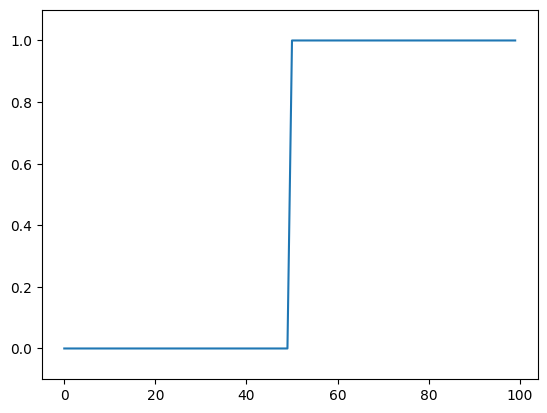

In [23]:
fig, ax = plt.subplots()
ax.plot(step_signal)
ax.margins(y=0.1)

#### Exercise: Can you predict what a convolution with the kernel `[-1, 0, 1]` does? Try thinking about it before running the cells below.


In [24]:
# compare correlate and convolve on an edge filter
result_corr = np.correlate(step_signal, np.array([-1, 0, 1]), mode="valid")

In [25]:
result_conv = np.convolve(step_signal, np.array([-1, 0, 1]), mode="valid")

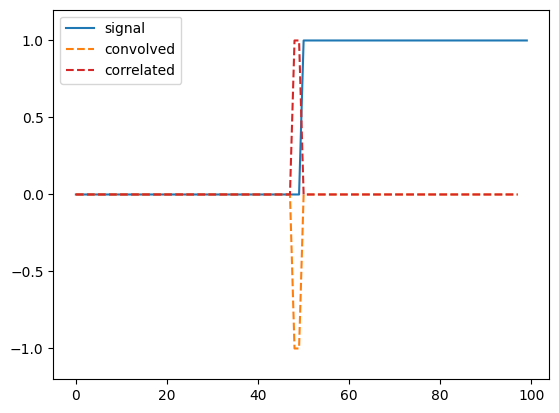

In [26]:
fig, ax = plt.subplots()
ax.plot(step_signal, label="signal")
ax.plot(result_conv, linestyle="dashed", label="convolved")
ax.plot(result_corr, linestyle="dashed", label="correlated", color="C3")
ax.legend(loc="upper left")
ax.margins(y=0.1)

(For technical signal processing reasons, convolutions actually occur "back to front" between the input array and the kernel. Correlations occur in the signal order, so we'll use correlate from now on.)


Whenever neighboring values are close, the filter response is close to 0. Right at the boundary of a step, we're subtracting a small value from a large value and and get a spike in the response. This spike "identifies" our edge.


### Commutativity and Associativity of filters


What if we try the same trick with our noisy signal?


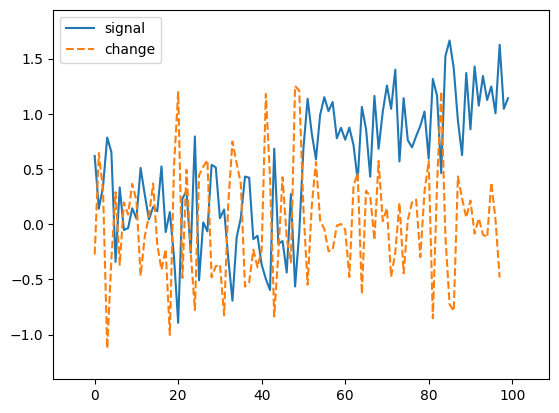

In [27]:
noisy_change = np.correlate(noisy_signal, np.array([-1, 0, 1]))
fig, ax = plt.subplots()
ax.plot(noisy_signal, label="signal")
ax.plot(noisy_change, linestyle="dashed", label="change")
ax.legend(loc="upper left")
ax.margins(0.1)

Oops! We lost our edge!


But recall that we smoothed the signal a bit by taking its neighbors. Perhaps we can do the same thing here. Actually, it turns out that we can do it _in any order_, so we can create a filter that combines both the difference and the mean:


In [28]:
mean_diff = np.correlate([-1, 0, 1], [1 / 3, 1 / 3, 1 / 3], mode="full")
print(mean_diff)

[-0.33333333 -0.33333333  0.          0.33333333  0.33333333]


```{Note}
We use `np.correlate` here, because it has the option to output a *wider* result than either of the two inputs.
```


Now we can use this to find our edge even in a noisy signal:


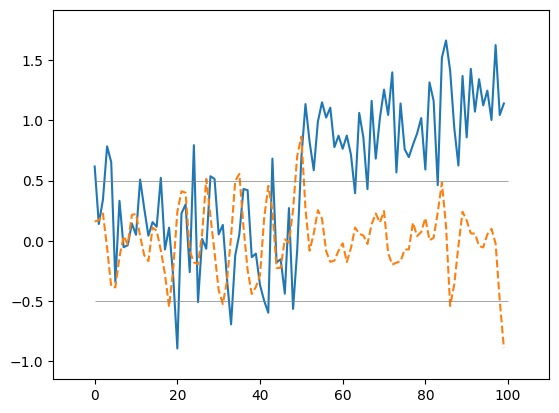

In [29]:
smooth_change = np.correlate(noisy_signal, mean_diff, mode="same")
fig, ax = plt.subplots()
ax.plot(noisy_signal, label="signal")
ax.plot(smooth_change, linestyle="dashed", label="change")
ax.margins(0.1)
ax.hlines([-0.5, 0.5], 0, 100, linewidth=0.5, color="gray")

This is an edge detector in 1D!
